In [ ]:
"""
This script reproduces the KGML-ag model development for predicting N2O fluxes in Licheng's paper: https://gmd.copernicus.org/articles/15/2839/2022/.
Dataset and code from the study can be downloaded at: https://doi.org/10.5281/zenodo.5504533.

The steps of model pretraining and fine-tuning are deonstrated, using the model (Statini_sq_N2OGRU) by incoporating code from two orginial files, 
pretrain_KGML-ag1_T5_6.ipynb and finetune_KGML-ag1_T3_4.ipynb, into a more readable and modularized manner.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from scipy.stats import gaussian_kde
import scipy.stats as stats

import subprocess as sp
import os
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

In [450]:
class R2Loss(nn.Module):
    #calculate coefficient of determination
    def forward(self, y_pred, y):
        var_y = torch.var(y, unbiased=False)
        return 1.0 - F.mse_loss(y_pred, y, reduction="mean") / var_y

def myloss_mul_sum(output, target, loss_weights):
    loss = 0.0
    losses = []
    tmp = 0.0
    nout=output.size(2)
    for i in range(nout):
        loss = loss + loss_weights[i]*torch.mean((output[:,:,i] - target[:,:,i])**2)
        tmp = tmp + loss_weights[i]*torch.mean((output[:,:,i] - target[:,:,i])**2)
        losses.append((loss_weights[i]*torch.mean((output[:,:,i] - target[:,:,i])**2)).item())
    losses.append(tmp.item())
    return loss, losses
    
class Statini_sq_N2OGRU(nn.Module):
    #input model variables are for each module
    def __init__(self, ninp1, ninp2, nhid, nlayers, nout1, nout2, dropout):
        super(Statini_sq_N2OGRU, self).__init__()
        if nlayers > 1:
            self.gru1 = nn.GRU(ninp1, nhid,nlayers,dropout=dropout)
            self.gru2 = nn.GRU(ninp2, nhid,nlayers,dropout=dropout)
        else:
            self.gru1 = nn.GRU(ninp1, nhid,nlayers)
            self.gru2 = nn.GRU(ninp2, nhid,nlayers)
        self.densor1 = nn.Linear(nhid, nout1)
        self.densor2 = nn.Linear(nhid, nout2)
        self.nhid = nhid
        self.nlayers = nlayers
        self.drop=nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1 #may change to a small value
        self.densor1.bias.data.zero_()
        self.densor1.weight.data.uniform_(-initrange, initrange)
        self.densor2.bias.data.zero_()
        self.densor2.weight.data.uniform_(-initrange, initrange)

    def forward(self, W_inputs, stat_ini_sq, hidden):
        inputs = torch.cat((W_inputs,stat_ini_sq),2)
        output1, hidden1 = self.gru1(inputs, hidden[0])
        output1 = self.densor1(self.drop(output1)) 
        inputs = torch.cat((W_inputs,output1),2)
        output2, hidden2 = self.gru2(inputs, hidden[1])
        output2 = self.densor2(self.drop(output2)) 
        #need to be careful what is the output orders!!!!!!!!!!!!!
        output=torch.cat((output2,output1),2)
        hidden=(hidden1,hidden2)
        return output, hidden
#bsz should be batch size
    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),\
                weight.new_zeros(self.nlayers, bsz, self.nhid))


class Statini_N2OGRU_v5(nn.Module):
    #input model variables are for each module
    def __init__(self, ninp1, ninp2, nhid1, nhid2, nlayers1, nlayers2, nout1, nout2, dropout):
        super(Statini_N2OGRU_v5, self).__init__()
        if nlayers1[0] > 1:
            self.gru1_1 = nn.GRU(ninp1[0], nhid1[0],nlayers1[0],dropout=dropout)
        else:
            self.gru1_1 = nn.GRU(ninp1[0], nhid1[0],nlayers1[0])
        if nlayers1[1] > 1:
            self.gru1_2 = nn.GRU(ninp1[1], nhid1[1],nlayers1[1],dropout=dropout)
        else:
            self.gru1_2 = nn.GRU(ninp1[1], nhid1[1],nlayers1[1])
        if nlayers1[2] > 1:
            self.gru1_3 = nn.GRU(ninp1[2], nhid1[2],nlayers1[2],dropout=dropout)
        else:
            self.gru1_3 = nn.GRU(ninp1[2], nhid1[2],nlayers1[2])
        if nlayers1[3] > 1:
            self.gru1_4 = nn.GRU(ninp1[3], nhid1[3],nlayers1[3],dropout=dropout)
        else:
            self.gru1_4 = nn.GRU(ninp1[3], nhid1[3],nlayers1[3])
        if nlayers2 > 1:
            self.gru2 = nn.GRU(ninp2, nhid2,nlayers2,dropout=dropout)
        else:
            self.gru2 = nn.GRU(ninp2, nhid2,nlayers2)

        self.densor1_1 = nn.Linear(nhid1[0], nout1[0])
        self.densor1_2 = nn.Linear(nhid1[1], nout1[1])
        self.densor1_3 = nn.Linear(nhid1[2], nout1[2])
        self.densor1_4 = nn.Linear(nhid1[3], nout1[3])
        self.densor2 = nn.Linear(nhid2, nout2)
        self.nhid1 = nhid1
        self.nhid2 = nhid2
        self.nlayers1 = nlayers1
        self.nlayers2 = nlayers2
        self.drop=nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1 #may change to a small value
        self.densor1_1.bias.data.zero_()
        self.densor1_1.weight.data.uniform_(-initrange, initrange)
        self.densor1_2.bias.data.zero_()
        self.densor1_2.weight.data.uniform_(-initrange, initrange)
        self.densor1_3.bias.data.zero_()
        self.densor1_3.weight.data.uniform_(-initrange, initrange)
        self.densor1_4.bias.data.zero_()
        self.densor1_4.weight.data.uniform_(-initrange, initrange)
        self.densor2.bias.data.zero_()
        self.densor2.weight.data.uniform_(-initrange, initrange)

    def forward(self, W_inputs, stat_ini_sq, hidden):
        #layer 1 for states simulation
        inputs = torch.cat((W_inputs,stat_ini_sq[:,:,0].view(stat_ini_sq.size(0),stat_ini_sq.size(1),1)),2)
        output1_1, hidden1_1 = self.gru1_1(inputs, hidden[0][0])
        output1_1 = self.densor1_1(self.drop(output1_1))
        inputs = torch.cat((W_inputs,stat_ini_sq[:,:,1].view(stat_ini_sq.size(0),stat_ini_sq.size(1),1)),2)
        output1_2, hidden1_2 = self.gru1_2(inputs, hidden[0][1])
        output1_2 = self.densor1_2(self.drop(output1_2))
        inputs = torch.cat((W_inputs,stat_ini_sq[:,:,2].view(stat_ini_sq.size(0),stat_ini_sq.size(1),1)),2)
        output1_3, hidden1_3 = self.gru1_3(inputs, hidden[0][2])
        output1_3 = self.densor1_3(self.drop(output1_3))
        inputs = torch.cat((W_inputs,stat_ini_sq[:,:,3].view(stat_ini_sq.size(0),stat_ini_sq.size(1),1)),2)
        output1_4, hidden1_4 = self.gru1_4(inputs, hidden[0][3])
        output1_4 = self.densor1_4(self.drop(output1_4))
        
        inputs = torch.cat((W_inputs,output1_1,output1_2,output1_3,output1_4),2)
        #layer two for N2O O2 and N2 simulation
        output2, hidden2 = self.gru2(inputs, hidden[1])
        output2 = self.densor2(self.drop(output2)) 
        #need to be careful what is the output orders!!!!!!!!!!!!!
        output=torch.cat((output2,output1_1,output1_2,output1_3,output1_4),2)
        
        hidden=((hidden1_1,hidden1_2,hidden1_3,hidden1_4),hidden2)
        return output, hidden
#bsz should be batch size
    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return ((weight.new_zeros(self.nlayers1[0], bsz, self.nhid1[0]),\
                weight.new_zeros(self.nlayers1[1], bsz, self.nhid1[1]),\
                weight.new_zeros(self.nlayers1[2], bsz, self.nhid1[2]),\
                weight.new_zeros(self.nlayers1[3], bsz, self.nhid1[3])),\
                weight.new_zeros(self.nlayers2, bsz, self.nhid2))
        
def get_ini(x,ind,nout):
    initials=[]
    for i in range(len(ind)):
        initials.append(x[:,:,ind[i]].view(x.size(0),x.size(1),nout[i]))
    return initials

def Z_norm(X):
    X_mean=X.mean()
    X_std=np.std(np.array(X))
    return (X-X_mean)/X_std, X_mean, X_std

def Z_norm_with_scaler(X,Xscaler):
    return (X-Xscaler[0])/Xscaler[1]
    
def Z_norm_reverse(X,Xscaler,units_convert):
    return (X*Xscaler[1]+Xscaler[0])*units_convert

#check whether start time is within the fertilized period
def dropout_check(start_t,fntime_ind):
    dropout_ind=False
    for t in fntime_ind:
        if start_t > t-10 and start_t < t+60:
            dropout_ind=True
    return dropout_ind
        
#sample data considering dropout and leadtime    
def sample_data(X,Y,slw,slw05,totsq,fnfeature_ind):
    maxit=int((totsq-slw)/slw05+1)
    #find the fertilized time
    fntime_ind=np.where(X[:,1,fnfeature_ind].view(-1).to("cpu").numpy()>0)[0]
    #get sliding window data with dropout method
    for it in range(maxit):
        if it==0:
            X_new = X[slw05*it:slw05*it+slw,:,:]
            Y_new = Y[slw05*it:slw05*it+slw,:,:]
        else:
            if not dropout_check(slw05*it,fntime_ind):
                X_new = torch.cat((X_new,X[slw05*it:slw05*it+slw,:,:]),1)
                Y_new = torch.cat((Y_new,Y[slw05*it:slw05*it+slw,:,:]),1)
    #get focused data only for fertilized period with random leading time
    for t in fntime_ind:
        if t != fntime_ind[-1]:
            leadtime=np.random.randint(t-60,t-10)
            X_new = torch.cat((X_new,X[leadtime:leadtime+slw,:,:]),1)
            Y_new = torch.cat((Y_new,Y[leadtime:leadtime+slw,:,:]),1)
    return X_new,Y_new

#sample data considering dropout and leadtime    
def sample_data_FN(X, Y, fn_ind):
    #find the fertilized time
    # print(np.sum(X[:,1,fn_ind].to("cpu").numpy()>0))
    fntime_ind=np.where(X[:,1,fn_ind].view(-1).to("cpu").numpy()>0)[0]
    # print(fntime_ind)
    #get focused data only for fertilized period with random leading time
    for t in fntime_ind:
        if t == fntime_ind[0]:
            X_new = X[t-30:t+90,:,:]
            Y_new = Y[t-30:t+90,:,:]
        else:
            X_new = torch.cat((X_new,X[t-30:t+90,:,:]),1)
            Y_new = torch.cat((Y_new,Y[t-30:t+90,:,:]),1)
    return X_new,Y_new
    
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss
    
def my_loss_weighted(output, target, mask):
    loss = torch.mean(((output - target)**2)*mask)
    return loss

In [ ]:
# create dataset
class KGML_N2O_dataset:

    def __init__(self,input_path: str, output_path:str, input_data:str, scaler_data:str) -> None:
        '''
        data_path: input data directory
        input_data: input dataset file name
        out_path: output directory
        '''
        self.data_path = input_path # os.path.abspath(data_path)
        self.out_path = output_path # os.path.abspath(out_path)
        self.input_data = input_path + input_data
        self.scaler_data = input_path + scaler_data
        self.fts_names = ['FERTZR_N','RADN','TMAX_AIR','TMIN_AIR','HMAX_AIR','HMIN_AIR','WIND','PRECN'] # 8 weather features
        self.fsp_names = ['PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC'] # 2 management + 6 soil features
        self.f_names = self.fts_names + self.fsp_names # total 16 features
        self.out_names = ['N2O_FLUX','CO2_FLUX', 'WTR_3','NH4_3', 'NO3_3'] # target 'N2O_FLUX' and 4 intermediate variables 
        self.n_f = len(self.f_names) # The number of features
        self.n_out = len(self.out_names)
        self.n_out1 = self.n_out - 1
        self.n_out2 = self.n_out - self.n_out1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    def load_data(self):
        self.data = torch.tensor(torch.load(self.input_data)) # test with a smaller dataset [:,:1000,:]
        self.X = self.data[:,:,:16]
        self.Y = self.data[:,:,16:]
        self.scalers = torch.tensor(torch.load(self.scaler_data))
        self.Xscaler = self.scalers[:16, :]
        self.Yscaler = self.scalers[16:, :]
        self.batch_total = self.data.size()[1] # site sample size in the 3 dimension data [DOY, site, features]
        print('data size is ', self.data.size())
        # print(torch.mean(self.X, dim=(0,1)), torch.mean(self.Y, dim=(0,1)))
        print('Yscaler', self.Yscaler)
        
    def train_test_split(self, train_ratio, test_ratio, val_ratio_to_train):
        if train_ratio and not test_ratio:
            test_ratio = 1 - train_ratio
        if not train_ratio and test_ratio:
            train_ratio = 1 - test_ratio
        if not val_ratio_to_train:
            val_ratio_to_train = 0.1
        # shuffle along site-year dimension. This randomization may be different every time
        shuffled_ix = torch.randperm(self.X.size()[1])
        self.X = self.X[:,shuffled_ix,:].to(self.device)
        self.Y = self.Y[:,shuffled_ix,:].to(self.device)
        
        self.total_n=self.X.size()[1]
        self.train_n=int((self.total_n * train_ratio) * (1-val_ratio_to_train))
        self.val_n=int((self.total_n * train_ratio) - self.train_n)
        self.test_n=self.total_n - self.train_n - self.val_n
        
        self.X_train=self.X[:,:self.train_n,:]
        self.X_val=self.X[:,self.train_n:(self.train_n+self.val_n),:]
        self.X_test=self.X[:,(self.train_n+self.val_n):,:]
        self.Y_train=self.Y[:,:self.train_n,:]
        self.Y_val=self.Y[:,self.train_n:(self.train_n+self.val_n),:]
        self.Y_test=self.Y[:,(self.train_n+self.val_n):,:]

        #sample the training data with sliding window
        self.X_train_new, self.Y_train_new = sample_data_FN(self.X_train, self.Y_train, fn_ind=0)
        self.X_val_new, self.Y_val_new = sample_data_FN(self.X_val, self.Y_val, fn_ind=0)
        self.X_test_new, self.Y_test_new = sample_data_FN(self.X_test, self.Y_test, fn_ind=0)
        # self.X_train_new, self.Y_train_new = self.X_train, self.Y_train
        # self.X_val_new, self.Y_val_new = self.X_val, self.Y_val
        # self.X_test_new, self.Y_test_new = self.X_test, self.Y_test



    # fine tune data augmentation: 
    # 16 h of data are randomly selected from 24 h observations to compute their mean as the daily value.
    # The total number of data is augmented to 122 d × 3 years × 6 chambers × 1000 data samples in this study.
    # X_train, Y_train are augmented outputs; X_train_d, Y_train_d are outputs without augmentation.
        
    def augment_finetune_data(self, dataset_path, scaler_path, val_chamber:list = [], augment_factor: int = None):
        scalers = torch.load(scaler_path)
        Xscaler = scalers[:16, :]
        Yscaler = scalers[16:, :]
        if not augment_factor:
            augn = 1000
        else:
            augn = augment_factor
        data0=torch.load(dataset_path)
        X1=data0['InputX1']
        X2=data0['InputX2']
        X3=data0['Soil_p']
        Y=data0['OutputY']
        X1names = ['tair','swdown','precip','spRH'] 
        X2names = ['Obs_prec','Fertilizer']
        X3names=['TSN','FBCU','PDOY','PDS','PDD','DDOY','PLANTT',\
                  'LAT','TLB','TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
        Ynames= ['N2O_FLUX','CO2_FLUX','NO3','NH4','WFPS']
        days=122
        nyear=3
        totnchamber=6
        if len(val_chamber) == 0:
            val_chamber.append(np.random.randint(0, 6))
        print(f"chamber {val_chamber} is used to validate")
        c_index = [0,1,2,3,4,5]
        c_val = val_chamber
        nc_val = len(c_val)
        c_train = c_index
        for num in c_val:
            c_train.remove(num)
        nc_train = len(c_train)
        print(X1.shape,X2.shape,X3.shape,Y.shape)
        pred_names=['N2O_FLUX','CO2_FLUX','NO3_3','NH4_3','WTR_3']
        #load data n
        Ynames_n = [0,1,2,3,4]
        #find the pred_names number in out_names, 
        #the no. of model output Y_train_pred[pred_names_n[i]] will be the related to Y_train[Ynames_n[i]]
        pred_names_n = []
        for i in range(len(pred_names)):
            pred_names_n.append(self.out_names.index(pred_names[i]))
            
        Y_units_convert=[-24.0,-24.0,1.0,1.0,(1-1.5/2.65)/100.0]
    
        X_train = np.zeros([days,augn*nyear*nc_train,len(self.f_names)],dtype=np.float32)
        Y_train = np.zeros([days,augn*nyear*nc_train,len(Ynames)],dtype=np.float32)
        Y_train_mask = np.zeros(Y_train.shape,dtype=np.float32)
        #for training without augmentation
        X_train_d = np.zeros([days,nyear*nc_train,len(self.f_names)],dtype=np.float32)
        Y_train_d = np.zeros([days,nyear*nc_train,len(Ynames)],dtype=np.float32)
        Y_train_d_mask = np.zeros(Y_train_d.shape,dtype=np.float32) 
        
        X_val=np.zeros([days,nyear*nc_val,len(self.f_names)],dtype=np.float32)
        Y_val=np.zeros([days,nyear*nc_val,len(Ynames)],dtype=np.float32)
        Y_val_mask=np.zeros(Y_val.shape,dtype=np.float32) 
    
        
        #Y_gt ground truth first day index, for initials creating
        Y_train_gt_1stind = np.zeros([nyear*nc_train,len(Ynames)], dtype=int)
        Y_val_gt_1stind = np.zeros([nyear*nc_val,len(Ynames)], dtype=int)
        print(Y_train_gt_1stind.shape,Y_val_gt_1stind.shape)
        #Method: Multidimensional Shifting using NumPy
        #method from https://ethankoch.medium.com/incredibly-fast-random-sampling-in-python-baf154bd836a
        #product index_array (num_samples,sample_size) within elements
        # constants
        # returning index
        num_samples = augn
        sample_size = 16 #sample 16 hours within one day
        num_elements = 24
        #elements = np.arange(num_elements)
        # probabilities should sum to 1
        probabilities = np.random.random(num_elements)
        probabilities /= np.sum(probabilities)
        def multidimensional_shifting(num_samples, sample_size, probabilities):
            # replicate probabilities as many times as `num_samples`
            replicated_probabilities = np.tile(probabilities, (num_samples, 1))
            # get random shifting numbers & scale them correctly
            random_shifts = np.random.random(replicated_probabilities.shape)
            random_shifts /= random_shifts.sum(axis=1)[:, np.newaxis]
            # shift by numbers & find largest (by finding the smallest of the negative)
            shifted_probabilities = random_shifts - replicated_probabilities
            return np.argpartition(shifted_probabilities, sample_size, axis=1)[:, :sample_size]
    
        #sample data from mesocosm site chambers
        for d in range(days):
            #for training data with data augmentation
            for y in range(nyear):
                for c in range(nc_train):
                    #get random sampled indexes
                    sample_indexes = multidimensional_shifting(num_samples, sample_size, probabilities)
                    #input data
                    #temperature
                    elements = np.tile(X1[d*24:(d+1)*24,y,c_train[c],0], (num_samples, 1)) # copy the hourly data num_samples times
                    output_samples = np.take_along_axis(elements, sample_indexes, axis=1) # sample the data based on random indexes
                    output_samples_tmax = output_samples.max(1)
                    output_samples_tdif = output_samples_tmax-output_samples.min(1)
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),2]=output_samples_tmax
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),3]=output_samples_tdif
                    X_train_d[d,y*nc_train+c,2] = np.max(X1[d*24:(d+1)*24,y,c_train[c],0])
                    X_train_d[d,y*nc_train+c,3] = np.max(X1[d*24:(d+1)*24,y,c_train[c],0])-\
                                                            np.min(X1[d*24:(d+1)*24,y,c_train[c],0])
                    #radiation need to convert from W/m-2 to MJ m-2 d-1, *3600*24*10-6
                    elements = np.tile(X1[d*24:(d+1)*24,y,c_train[c],1], (num_samples, 1)) # copy the hourly data num_samples times
                    output_samples = np.take_along_axis(elements, sample_indexes, axis=1) # sample the data based on random indexes
                    output_samples_rad = output_samples.mean(1)*(3600.0*24.0*(10**(-6)))
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),1]=output_samples_rad
                    X_train_d[d,y*nc_train+c,1] = np.mean(X1[d*24:(d+1)*24,y,c_train[c],1])*(3600.0*24.0*(10**(-6)))
                    #humidity
                    elements = np.tile(X1[d*24:(d+1)*24,y,c_train[c],3], (num_samples, 1)) # copy the hourly data num_samples times
                    output_samples = np.take_along_axis(elements, sample_indexes, axis=1) # sample the data based on random indexes
                    output_samples_hmax = output_samples.max(1)
                    output_samples_hdif = output_samples_hmax - output_samples.min(1)
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),4]=output_samples_hmax
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),5]=output_samples_hdif
                    X_train_d[d,y*nc_train+c,4] = np.max(X1[d*24:(d+1)*24,y,c_train[c],3])
                    X_train_d[d,y*nc_train+c,5] = np.max(X1[d*24:(d+1)*24,y,c_train[c],3]) - \
                                                            np.min(X1[d*24:(d+1)*24,y,c_train[c],3])
                    #sample Y data
                    for ffy in range(len(Ynames)): 
                        element=Y[d*24:(d+1)*24,y,c_train[c],ffy]
                        nan_nums=np.count_nonzero(np.isnan(element))
                        if  nan_nums < 16:
                            # copy the hourly data num_samples times
                            elements = np.tile(element, (num_samples, 1)) 
                            # sample the data based on random indexes
                            output_samples = np.take_along_axis(elements, sample_indexes, axis=1) 
                            #convert to right units (n2O g N m-2 h-1 to d-1)
                            output_samples_n2o = np.nanmean(output_samples,axis=1)
                            # need to be direction to soil
                            Y_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),ffy]= output_samples_n2o*Y_units_convert[ffy]
                            Y_train_mask[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),ffy] = (24.0-float(nan_nums))/24.0
                            
                            Y_train_d[d,y*nc_train+c,ffy]= np.nanmean(Y[d*24:(d+1)*24,y,c_train[c],ffy])*\
                                                            Y_units_convert[ffy] #convert 
                            Y_train_d_mask[d,y*nc_train+c,ffy] = (24.0-float(nan_nums))/24.0
                            #get the first day of ground truth
                            if Y_train_gt_1stind[y*nc_train+c,ffy] == 0:
                                Y_train_gt_1stind[y*nc_train+c,ffy] = d
    
                        else:
                            # if missing value >=16, we use -999 represent nan
                            Y_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),ffy]=-999.0 
                            Y_train_mask[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),ffy] = 0.0
                            
                            Y_train_d[d,y*nc_train+c,ffy]=-999.0 
                            Y_train_d_mask[d,y*nc_train+c,ffy] = 0.0
                    #deal with other training variables
                    #fertilizer
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),0] = X2[d,y,c_train[c],1]
                    X_train_d[d,y*nc_train+c,0] = X2[d,y,c_train[c],1]
                    #wind
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),6] = 0.05
                    X_train_d[d,y*nc_train+c,6] = 0.05
                    #precipitation
                    X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),7] = X2[d,y,c_train[c],0]
                    X_train_d[d,y*nc_train+c,7] = X2[d,y,c_train[c],0]
                    for i in range(len(self.fsp_names)):
                        X_train[d,augn*(y*nc_train+c):augn*(y*nc_train+c+1),8+i] = X3[d,y,c_train[c],X3names.index(self.fsp_names[i])]
                        X_train_d[d,y*nc_train+c,8+i] = X3[d,y,c_train[c],X3names.index(self.fsp_names[i])]
    
    
        #load the validation data
        for d in range(days):
            for y in range(nyear):
                for c in range(nc_val):
                    #temperature
                    X_val[d,y*nc_val+c,2] = np.max(X1[d*24:(d+1)*24,y,c_val[c],0])
                    X_val[d,y*nc_val+c,3] = np.max(X1[d*24:(d+1)*24,y,c_val[c],0])-\
                                                            np.min(X1[d*24:(d+1)*24,y,c_val[c],0])
                    #radiation
                    X_val[d,y*nc_val+c,1] = np.mean(X1[d*24:(d+1)*24,y,c_val[c],1])*(3600.0*24.0*(10**(-6)))
                    #humidity
                    X_val[d,y*nc_val+c,4] = np.max(X1[d*24:(d+1)*24,y,c_val[c],3])
                    X_val[d,y*nc_val+c,5] = np.max(X1[d*24:(d+1)*24,y,c_val[c],3]) - \
                                                            np.min(X1[d*24:(d+1)*24,y,c_val[c],3])
                    #Y data
                    for ffy in range(len(Ynames)): 
                        element = Y[d*24:(d+1)*24,y,c_val[c],ffy]
                        nan_nums=np.count_nonzero(np.isnan(element))
                        if  nan_nums < 16:
                            Y_val[d,y*nc_val+c,ffy] = np.nanmean(element)*Y_units_convert[ffy] #convert 
                            Y_val_mask[d,y*nc_val+c,ffy] = (24.0-float(nan_nums))/24.0
                            #get the first day of ground truth
                            if Y_val_gt_1stind[y*nc_val+c,ffy] == 0:
                                Y_val_gt_1stind[y*nc_val+c,ffy] = d
                        else:
                            Y_val[d,y*nc_val+c,ffy] = -999.0 # if missing value >=16, we use -999 represent nan
                            Y_val_mask[d,y*nc_val+c,ffy] = 0.0
                    #deal with other training variables
                    #fertilizer
                    X_val[d,y*nc_val+c,0] = X2[d,y,c_val[c],1]
                    #wind
                    X_val[d,y*nc_val+c,6] = 0.05
                    #precipitation
                    X_val[d,y*nc_val+c,7] = X2[d,y,c_val[c],0]
                    for i in range(len(self.fsp_names)):
                        X_val[d,y*nc_val+c,8+i] = X3[d,y,c_val[c],X3names.index(self.fsp_names[i])]
    
        print(X_train.shape,Y_train.shape,X_train_d.shape,Y_train_d.shape,X_val.shape,Y_val.shape)
        # print(Xscaler.shape, Yscaler.shape,X_train.shape[2])
        #Z-norm the matrix
        for i in range(X_train.shape[2]):
            X_train[:,:,i]=Z_norm_with_scaler(X_train[:,:,i],Xscaler[i,:])
            X_train_d[:,:,i]=Z_norm_with_scaler(X_train_d[:,:,i],Xscaler[i,:])
            X_val[:,:,i]=Z_norm_with_scaler(X_val[:,:,i],Xscaler[i,:])
        for i in range(len(Ynames_n)):
            Y_train[:,:,Ynames_n[i]]=Z_norm_with_scaler(Y_train[:,:,Ynames_n[i]],Yscaler[pred_names_n[i],:])
            Y_train_d[:,:,Ynames_n[i]]=Z_norm_with_scaler(Y_train_d[:,:,Ynames_n[i]],Yscaler[pred_names_n[i],:])
            Y_val[:,:,Ynames_n[i]]=Z_norm_with_scaler(Y_val[:,:,Ynames_n[i]],Yscaler[pred_names_n[i],:])

        self.augn = augn
        self.c_val = c_val
        self.val_chamber = val_chamber
        self.aug_X_train = X_train
        self.aug_Y_train = Y_train
        self.aug_X_train_d = X_train_d
        self.aug_Y_train_d = Y_train_d
        self.aug_X_val = X_val
        self.aug_Y_val = Y_val
        self.aug_Y_train_mask = Y_train_mask
        self.aug_Y_val_mask = Y_val_mask
        self.aug_Y_train_d_mask = Y_train_d_mask
        self.aug_Y_train_gt_1stind = Y_val_gt_1stind
        self.aug_Y_val_gt_1stind = Y_val_gt_1stind



class KGML_N2O:

    def __init__(self,input_path: str, output_path:str, input_data:str, dataset: KGML_N2O_dataset, pretrained_model:str=None) -> None:
        '''
        data_path: input data directory
        input_data: input dataset file name
        out_path: output directory
        '''
        self.data_path = input_path # os.path.abspath(data_path)
        self.out_path = output_path # os.path.abspath(out_path)
        self.input_data = input_path + input_data
        self.fts_names = ['FERTZR_N','RADN','TMAX_AIR','TMIN_AIR','HMAX_AIR','HMIN_AIR','WIND','PRECN'] # 8 weather features
        self.fsp_names = ['PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC'] # 2 management + 6 soil features
        self.f_names = self.fts_names + self.fsp_names # total 16 features
        self.out_names = ['N2O_FLUX','CO2_FLUX', 'WTR_3','NH4_3', 'NO3_3'] # target 'N2O_FLUX' and 4 intermediate variables 
        self.n_f = len(self.f_names) # The number of features
        self.n_out = len(self.out_names)
        self.n_out1 = self.n_out - 1
        self.n_out2 = self.n_out - self.n_out1
        if pretrained_model:
            self.pretrained_model = pretrained_model
        else:
            self.pretrained_model = None
        self.dataset = dataset

        # if not torch.cuda.is_available():
        #     raise RuntimeError("GPU is not available. Initialization failed.")
        # Proceed with GPU setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print("Using device:", self.device)
    
    def load_model(self, drop_out:float = 0.2, n_hidden=64, n_layer=2, seq_len:int = 365, model_version=None):
        '''
        drop_out # drop out ratio
        n_hidden # hidden state number
        n_layer # layer of GRU
        seq_len # time sequence length
        '''  
        self.n_hidden = n_hidden
        self.n_layer = n_layer
        self.drop_out = drop_out
        
        # Format the model version string
        current_time = time.localtime()
        if not model_version:
            model_version = 'n2o_gru_{}-{}-{}.sav'.format(current_time.tm_year, current_time.tm_mon, current_time.tm_mday)

        self.model_version = model_version
        self.path_save = self.out_path + self.model_version + '.sav'

        #output 4 in first module and 1 in second module
        self.model = Statini_sq_N2OGRU(self.n_f+self.n_out1, self.n_f+self.n_out1,n_hidden,n_layer,self.n_out1,self.n_out2, drop_out)
        if self.pretrained_model:
            checkpoint = torch.load(self.pretrained_model, weights_only=False, map_location=torch.device('mps'))
            self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        
        print(self.model)
        params = list(self.model.parameters())
        print(len(params))
        print(params[5].size())  # conv1's .weight
        print("Model's state_dict:")
        for param_tensor in self.model.state_dict():
            print(param_tensor, "\t", self.model.state_dict()[param_tensor].size())

        
    def train(self, LR=0.0001, step_size=600, slw=120, gamma=0.5, batch_size=500, maxepoch=3000):

        X_train_new, Y_train_new = self.dataset.X_train_new, self.dataset.Y_train_new
        X_val_new, Y_val_new = self.dataset.X_val_new, self.dataset.Y_val_new
        X_test_new, Y_test_new = self.dataset.X_test_new, self.dataset.Y_test_new
        
        starttime=time.time()
        optimizer = optim.Adam(self.model.parameters(), lr=LR) #add weight decay normally 1-9e-4
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        batch_total = X_train_new.size(1)
        n_out = self.n_out
        compute_r2 = R2Loss()
        # loss initials
        loss_val_best = 500000
        R2_best = 0.5
        loss_weights=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]  
        train_losses = []
        val_losses = []
        
        self.model.train()
        for epoch in range(maxepoch):
            train_loss = 0.0
            val_loss = 0.0
            train_losses_cum = [0.0] * (n_out+1)
            val_losses_cum = [0.0] * (n_out+1)
            Y_pred_all = torch.zeros(Y_train_new.size(),device=self.device)
            #shuffled the training data
            shuffled_b = torch.randperm(X_train_new.size()[1]) 
            X_train_new = X_train_new[:,shuffled_b,:]
            Y_train_new = Y_train_new[:,shuffled_b,:]
            self.model.zero_grad()
            for bb in range(int(batch_total/batch_size)):
                hidden = self.model.init_hidden(batch_size)
                #generate initial sequence 
                statini_sq = Y_train_new[0,bb*batch_size:(bb+1)*batch_size,-self.n_out1:].\
                             view(1,batch_size,self.n_out1).repeat(X_train_new.size(0),1,1)
                #consider midpoints
                Y_pred,hidden = self.model(X_train_new[:,bb*batch_size:(bb+1)*batch_size,:],\
                                        statini_sq,\
                                        hidden)
                loss, losses = myloss_mul_sum(Y_pred, Y_train_new[:,bb*batch_size:(bb+1)*batch_size,:].view(slw,batch_size,n_out),\
                                         loss_weights)
                hidden[0].detach_()
                hidden[1].detach_()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    train_loss = train_loss+loss.item()
                    train_losses_cum = [a+b for a,b in zip(train_losses_cum, losses)]
                    Y_pred_all[:,bb*batch_size:(bb+1)*batch_size,:]=Y_pred[:,:,:]

            scheduler.step()
            #validation
            self.model.eval()
            with torch.no_grad():
                train_loss = train_loss/(batch_total/batch_size)
                train_losses_mean = [ls/(batch_total/batch_size) for ls in train_losses_cum]
                train_losses.append(train_losses_mean)
                #r2 only for n2o
                train_R2 = compute_r2(Y_pred_all[:,:,0].contiguous().view(-1),Y_train_new[:,:,0].contiguous().view(-1)).item()
                Y_val_pred = torch.zeros(Y_val_new.size(),device=self.device)
                #generate initial sequence
                statini_sq = Y_val_new[0,:,-self.n_out1:].view(1,Y_val_new.size(1),self.n_out1).repeat(X_val_new.size(0),1,1)
                #change intitial for year round simulation
                hidden = self.model.init_hidden(X_val_new.size(1))   
                Y_val_pred, hidden = self.model(X_val_new,statini_sq, hidden)
                loss, losses = myloss_mul_sum(Y_val_pred, Y_val_new,loss_weights)
                val_loss = loss.item()
                val_losses.append(losses)
                #r2 only for n2o
                val_R2 = compute_r2(Y_val_pred[:,:,0].contiguous().view(-1),Y_val_new[:,:,0].contiguous().view(-1)).item()
                if val_loss < loss_val_best and val_R2 > R2_best:
                    loss_val_best=val_loss
                    R2_best = val_R2
                    f0 = open(self.path_save,'w')
                    f0.close()
                    #os.remove(self.path_save)
                    torch.save({'epoch': epoch,
                            'model_state_dict': self.model.state_dict(),
                            'R2': train_R2,
                            'loss': train_loss,
                            'los_val': val_loss,
                            'R2_val': val_R2,
                            }, self.path_save)    
                print("finished training epoch", epoch+1)
                mtime = time.time()
                print("train_loss: ", train_loss, "train_R2", train_R2,"val_loss:",val_loss,"val_R2", val_R2,\
                      "loss val best:",loss_val_best,"R2 val best:",R2_best, f"Spending time: {mtime - starttime}s")
        
                if train_R2 > 0.99:
                    break
            self.model.train()
        endtime = time.time()
        self.dataset.Y_val_pred = Y_val_pred
        path_fs = self.path_save+'fs'
        torch.save({'train_losses': train_losses,
                    'val_losses': val_losses,
                    'model_state_dict': self.model.state_dict(),
                    }, path_fs)
        print("final train_loss:",train_loss,"final train_R2:",train_R2,"val_loss:",val_loss,"loss validation best:",loss_val_best)
        print(f"total Training time: {endtime - starttime}s")


    def test(self):
        starttime = time.time()
        X_test_new = self.dataset.X_test_new
        Y_test_new = self.dataset.Y_test_new
        compute_r2 = R2Loss()
        loss_weights=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]  
        ####read in a pretrained model with full sample
        path_save = self.path_save
        
        with torch.no_grad():
            checkpoint = torch.load(path_save, map_location = self.device, weights_only=False)
            model_trained = Statini_sq_N2OGRU(self.n_f+self.n_out1, self.n_f+self.n_out1, self.n_hidden, self.n_layer, self.n_out1,self.n_out2, self.drop_out)
            model_trained.load_state_dict(checkpoint['model_state_dict'])
            model_trained.to(self.device) #too large for GPU, kif not enough, change to cpu
            model_trained.eval()
            epoch = checkpoint['epoch']
            # print(epoch)


            with torch.no_grad():
                statini_sq = Y_test_new[0,:,-self.n_out1:].view(1,Y_test_new.size(1),self.n_out1).repeat(Y_test_new.size(0),1,1)
                #change intitial for year round simulation
                hidden = self.model.init_hidden(X_test_new.size(1))   
                Y_pred, hidden = self.model(X_test_new,statini_sq, hidden)
                # Y_pred[:,sbb:ebb,:] = Y_pred_t[:,:,:]
                loss, losses = myloss_mul_sum(Y_pred, Y_test_new, loss_weights)
                test_loss = loss.item()
                #r2 only for n2o
                test_R2 = compute_r2(Y_pred[:,:,0].contiguous().view(-1),Y_test_new[:,:,0].contiguous().view(-1)).item()
            self.dataset.Y_test_pred = Y_pred
            endtime = time.time()
            print('Test loss:', test_loss, 'test R2:', test_R2)
            print(f"Total spending time: {endtime - starttime}s")



    def generate_ini_stats(self, stat_values,Y_gt,Y_gt_1stind,aug_n,pred_names_n,Ynames_n):
        statini_sq = torch.zeros([Y_gt.size(0),Y_gt.size(1),len(stat_values)],device=self.device)
        for i in range(len(stat_values)):
            statini_sq[:,:,i]=stat_values[i]
        for i in range(len(pred_names_n)):
            for cc in range(len(Y_gt_1stind[:,Ynames_n[i]])):
                if Y_gt_1stind[cc,Ynames_n[i]] != 0:
                    statini_sq[Y_gt_1stind[cc,Ynames_n[i]]:,cc*aug_n:(cc+1)*aug_n,pred_names_n[i]-1]= \
                                                        Y_gt[Y_gt_1stind[cc,Ynames_n[i]],cc*aug_n:(cc+1)*aug_n,Ynames_n[i]].\
                                                        view(1,aug_n).repeat(Y_gt.size(0)-Y_gt_1stind[cc,Ynames_n[i]],1)
        return statini_sq

    
    def fine_tune(self, basic_path, model_load: str = 'n2o_gru_mesotest_v4_exp1.sav', maxepoch_l1 = 20000, maxepoch_l2 = 800, lr_adam = 0.0001*0.5, slw = 122, step_size=5000, gamma=0.5):    
        X1names = ['tair','swdown','precip','spRH'] 
        X2names = ['Obs_prec','Fertilizer']
        X3names=['TSN','FBCU','PDOY','PDS','PDD','DDOY','PLANTT',\
                  'LAT','TLB','TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
        Ynames= ['N2O_FLUX','CO2_FLUX','WFPS','NH4','NO3']
        pred_names=['N2O_FLUX','CO2_FLUX','WTR_3','NH4_3','NO3_3']
        Ynames_n = [0,1,2,3,4]
        stat_values=[-1.0,0.2,0.0,20.0]
        pred_names_n = []
        for i in range(len(pred_names)):
            pred_names_n.append(self.out_names.index(pred_names[i]))

        # declare split data and masks from KGML_N2O_dataset
        device = self.device
        augn = self.dataset.augn
        X_train = torch.from_numpy(self.dataset.aug_X_train).to(device)
        Y_train = torch.from_numpy(self.dataset.aug_Y_train).to(device)
        X_train_d = torch.from_numpy(self.dataset.aug_X_train_d).to(device)
        Y_train_d = torch.from_numpy(self.dataset.aug_Y_train_d).to(device)
        X_val = torch.from_numpy(self.dataset.aug_X_val).to(device)
        Y_val = torch.from_numpy(self.dataset.aug_Y_val).to(device)
        Y_train_mask = torch.from_numpy(self.dataset.aug_Y_train_mask).to(device)
        Y_val_mask = torch.from_numpy(self.dataset.aug_Y_val_mask).to(device)
        Y_train_d_mask = torch.from_numpy(self.dataset.aug_Y_train_d_mask).to(device)
        Y_train_gt_1stind = torch.from_numpy(self.dataset.aug_Y_train_gt_1stind).to(device)
        Y_val_gt_1stind = torch.from_numpy(self.dataset.aug_Y_val_gt_1stind).to(device)
        
        Y_train_maskb = Y_train_mask.ge(0.25)
        Y_val_maskb = Y_val_mask.ge(0.25)
        Y_train_d_maskb = Y_train_d_mask.ge(0.25)
        #retrain the model
        #########################prepare the fake initials
        #Generate initials considering the ground truth:
        #Y_gt is the ground truth, using for validate or train
    
        
        #generate initials
        
        stats_train_sq = self.generate_ini_stats(stat_values, Y_train,\
                                            Y_train_gt_1stind, augn, pred_names_n[1:],Ynames_n[1:])
        stats_val_sq = self.generate_ini_stats(stat_values,Y_val,\
                                                    Y_val_gt_1stind,1,pred_names_n[1:],Ynames_n[1:])
        
        #generate initials for training without 
        stats_train_d_sq = self.generate_ini_stats(stat_values,Y_train_d,\
                                            Y_train_gt_1stind,1,pred_names_n[1:],Ynames_n[1:])
    
        def generate_fake_stats(stat_values,batch):
            fake_stats=torch.zeros([1,batch,len(stat_values)],device=device)
            for i in range(len(stat_values)):
                fake_stats[:,:,i]=stat_values[i]
            return fake_stats
        
        
        
        ################train the model start
        model_version=model_load[-4] + '_' + str(self.dataset.c_val[0]+1)+".sav"
        starttime = time.time()
        ####################freeze the second layer, only train the first layer
        #only train first layer and states variables and without augmentation
        ###load model
        path_load = basic_path+model_load
        checkpoint = torch.load(path_load, map_location = self.device, weights_only=False)
        model1 = Statini_sq_N2OGRU(self.n_f+self.n_out1, self.n_f+self.n_out1, self.n_hidden, self.n_layer, self.n_out1,self.n_out2, self.drop_out)
        model1.load_state_dict(checkpoint['model_state_dict'])
                
        model1.to(device) #too large for GPU, kif not enough, change to cpu
        print(model1)
        loss_val_best = 500000
        R2_best = 0.2
        compute_r2 = R2Loss()
        path_save = basic_path+model_version+'1l'
        
        ##freeze 2nd layer
        for name, param in model1.named_parameters():
            if param.requires_grad and ('gru2' in name or 'densor2' in name):
                param.requires_grad = False
            if param.requires_grad:
                print(name)
                
        
        optimizer = optim.Adam(model1.parameters(), lr=lr_adam) #add weight decay normally 1-9e-4
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
        # print(X_train_d.size(),X_val.size())
        batch_total = X_train_d.size(1)
        batch_size = batch_total  # this is the batch size for training
        train_losses = []
        val_losses = []
        model1.train()
        
        for epoch in range(maxepoch_l1):
            train_loss = 0.0
            val_loss = 0.0
            Y_pred_all = torch.zeros([Y_train_d.size(0), Y_train_d.size(1),len(self.out_names)],device=device)
            #shuffled the training data
            shuffled_b = torch.randperm( X_train_d.size()[1]) 
            X_train_new =  X_train_d[:,shuffled_b,:]
            Y_train_new =  Y_train_d[:,shuffled_b,:]
            Y_train_mask_new =  Y_train_d_mask[:,shuffled_b,:]
            Y_train_maskb_new =  Y_train_d_maskb[:,shuffled_b,:]
            stats_train_sq_new = stats_train_d_sq[:,shuffled_b,:]  
            model1.zero_grad()
            for bb in range(int(batch_total/batch_size)):
                hidden = model1.init_hidden(batch_size)
                Y_pred,hidden = model1(X_train_new[:,bb*batch_size:(bb+1)*batch_size,:],\
                                       stats_train_sq_new[:,bb*batch_size:(bb+1)*batch_size,:],hidden)
                #need to adjust the loss for missing data based on mask
                loss = my_loss_weighted(Y_pred[:,:,pred_names_n[1:]], \
                                        Y_train_new[:,bb*batch_size:(bb+1)*batch_size,Ynames_n[1:]],\
                                        Y_train_mask_new[:,bb*batch_size:(bb+1)*batch_size,Ynames_n[1:]])
                hidden[0].detach_() 
                hidden[1].detach_()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    train_loss=train_loss+loss.item()
                    Y_pred_all[:,bb*batch_size:(bb+1)*batch_size,:]=Y_pred[:,:,:]
           
        
            scheduler.step()
            #validation
            model1.eval()
            with torch.no_grad():
                train_loss=train_loss/(batch_total/batch_size)
                train_losses.append(train_loss)
                #mask out the points
                Y_train_new_masked = torch.masked_select(Y_train_new[:,:,Ynames_n[1:]], Y_train_maskb_new[:,:,Ynames_n[1:]])
                Y_pred_all_masked = torch.masked_select(Y_pred_all[:,:,pred_names_n[1:]], Y_train_maskb_new[:,:,Ynames_n[1:]])
                train_R2 = compute_r2(Y_pred_all_masked.contiguous().view(-1),\
                                    Y_train_new_masked.contiguous().view(-1)).item()
                ########################validation
                Y_val_pred = torch.zeros([Y_val.size(0),Y_val.size(1),len(self.out_names)],device=device)
                hidden = model1.init_hidden(X_val.size(1))
                #print(stats_val_sq[:,2,0])
                Y_val_pt, hidden = model1(X_val,stats_val_sq,hidden)
                Y_val_pred[:,:,:] = Y_val_pt[:,:,:]
                loss = my_loss_weighted(Y_val_pred[:,:,pred_names_n[1:]],Y_val[:,:,Ynames_n[1:]],Y_val_mask[:,:,Ynames_n[1:]])
                val_loss=loss.item()
                val_losses.append(val_loss)
                Y_val_masked=torch.masked_select(Y_val[:,:,Ynames_n[1:]], Y_val_maskb[:,:,Ynames_n[1:]])
                Y_val_pred_masked=torch.masked_select(Y_val_pred[:,:,pred_names_n[1:]], Y_val_maskb[:,:,Ynames_n[1:]])
                val_R2=compute_r2(Y_val_pred_masked.contiguous().view(-1),Y_val_masked.contiguous().view(-1)).item()
                if val_loss < loss_val_best and val_R2 > R2_best:
                    loss_val_best=val_loss
                    R2_best = val_R2
                    f0 = open(path_save,'w')
                    f0.close()
                    #os.remove(path_save)
                    torch.save({'epoch': epoch,
                            'model_state_dict': model1.state_dict(),
                            'R2': train_R2,
                            'loss': train_loss,
                            'los_val': val_loss,
                            'R2_val': val_R2,
                            }, path_save)
                if epoch%1000 == 999:
                    print("finished training 1st layer epoch", epoch+1)
                    mtime = time.time()
                    print("train_loss: ", train_loss, "train_R2", train_R2,"val_loss:",val_loss,"val_R2", val_R2,\
                          "loss val best:",loss_val_best,"R2 val best:",R2_best, f"Spending time: {mtime - starttime}s")
                if train_R2 > 0.99:
                    break
                #adding early stop
            model1.train()
    
        path_fs = path_save + 'fs'
        torch.save({'train_losses': train_losses,
                    'val_losses': val_losses,
                    'model_state_dict_fs': model1.state_dict(),
                    }, path_fs)
        #####finished training first layer
        
        ####################train the second layer, freeze first layer
        
        ###load the trained model:
        path_load = basic_path+model_version+'1l'
        # print(path_load)
        checkpoint = torch.load(path_load, map_location = self.device, weights_only=False)
        model1 = Statini_sq_N2OGRU(self.n_f+self.n_out1, self.n_f+self.n_out1, self.n_hidden, self.n_layer, self.n_out1,self.n_out2, self.drop_out)
        model1.load_state_dict(checkpoint['model_state_dict'])
        model1.to(device) #too large for GPU, kif not enough, change to cpu
        print(model1)
        loss_val_best = 500000
        R2_best=0.2
        path_save = basic_path+model_version+'2l'
        
        for name, param in model1.named_parameters():
            param.requires_grad = True
        ###freeze 1st layer
        for name, param in model1.named_parameters():
            if param.requires_grad and ('gru1' in name or 'densor1' in name):
                param.requires_grad = False
            if param.requires_grad:
                print(name)
    
    
        optimizer = optim.Adam(model1.parameters(), lr=lr_adam) #add weight decay normally 1-9e-4
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        print(X_train.size(), X_val.size())
        batch_total=X_train_d.size(1)
        batch_size=batch_total  # this is the batch size for training
        train_losses = []
        val_losses = []
        model1.train()
        for epoch in range(maxepoch_l2):
            train_loss=0.0
            val_loss=0.0
            Y_pred_all = torch.zeros([Y_train_d.size(0),Y_train_d.size(1),len(self.out_names)],device=device)
            #shuffled the training data
            shuffled_b = torch.randperm(X_train_d.size()[1]) 
            X_train_new = X_train_d[:,shuffled_b,:] 
            Y_train_new = Y_train_d[:,shuffled_b,:]
            Y_train_mask_new = Y_train_d_mask[:,shuffled_b,:]
            Y_train_maskb_new = Y_train_d_maskb[:,shuffled_b,:]
            stats_train_sq_new = stats_train_d_sq[:,shuffled_b,:]  
            model1.zero_grad()
            for bb in range(int(batch_total/batch_size)):
                hidden = model1.init_hidden(batch_size)
                
                Y_pred,hidden = model1(X_train_new[:,bb*batch_size:(bb+1)*batch_size,:],\
                                       stats_train_sq_new[:,bb*batch_size:(bb+1)*batch_size,:],hidden)
                #need to adjust the loss for missing data based on mask
                loss = my_loss_weighted(Y_pred[:,:,pred_names_n[0]], \
                                        Y_train_new[:,bb*batch_size:(bb+1)*batch_size,Ynames_n[0]],\
                                        Y_train_mask_new[:,bb*batch_size:(bb+1)*batch_size,Ynames_n[0]])
                hidden[0].detach_() 
                hidden[1].detach_()
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    train_loss=train_loss+loss.item()
                    Y_pred_all[:,bb*batch_size:(bb+1)*batch_size,:]=Y_pred[:,:,:]
    
    
            scheduler.step()
            #validation
            model1.eval()
            with torch.no_grad():
                train_loss=train_loss/(batch_total/batch_size)
                train_losses.append(train_loss)
                #mask out the points
                Y_train_new_masked=torch.masked_select(Y_train_new[:,:,Ynames_n[0]], Y_train_maskb_new[:,:,Ynames_n[0]])
                Y_pred_all_masked=torch.masked_select(Y_pred_all[:,:,pred_names_n[0]], Y_train_maskb_new[:,:,Ynames_n[0]])
                train_R2=compute_r2(Y_pred_all_masked.contiguous().view(-1),\
                                    Y_train_new_masked.contiguous().view(-1)).item()
                ########################validation
                Y_val_pred=torch.zeros([Y_val.size(0),Y_val.size(1),len(self.out_names)],device=device)
                hidden = model1.init_hidden(X_val.size(1))
                #print(stats_val_sq[:,2,0])
                Y_val_pt, hidden = model1(X_val,stats_val_sq,hidden)
                Y_val_pred[:,:,:] = Y_val_pt[:,:,:]
                loss = my_loss_weighted(Y_val_pred[:,:,pred_names_n[0]],Y_val[:,:,Ynames_n[0]],Y_val_mask[:,:,Ynames_n[0]])
                val_loss=loss.item()
                val_losses.append(val_loss)
                Y_val_masked=torch.masked_select(Y_val[:,:,Ynames_n[0]], Y_val_maskb[:,:,Ynames_n[0]])
                Y_val_pred_masked=torch.masked_select(Y_val_pred[:,:,pred_names_n[0]], Y_val_maskb[:,:,Ynames_n[0]])
                val_R2=compute_r2(Y_val_pred_masked.contiguous().view(-1),Y_val_masked.contiguous().view(-1)).item()
                if val_loss < loss_val_best and val_R2 > R2_best:
                    loss_val_best=val_loss
                    R2_best = val_R2
                    f0=open(path_save,'w')
                    f0.close()
                    #os.remove(path_save)
                    torch.save({'epoch': epoch,
                            'model_state_dict': model1.state_dict(),
                            'R2': train_R2,
                            'loss': train_loss,
                            'los_val': val_loss,
                            'R2_val': val_R2,
                            }, path_save)
                if epoch%1000 == 999:
                    print("finished training epoch", epoch+1)
                    mtime=time.time()
                    print("train_loss: ", train_loss, "train_R2", train_R2,"val_loss:",val_loss,"val_R2", val_R2,\
                          "loss val best:",loss_val_best,"R2 val best:",R2_best, f"Spending time: {mtime - starttime}s")
                if train_R2 > 0.99:
                    break
                #adding early stop
            model1.train()
        endtime=time.time()
        path_fs = path_save+'fs'
        torch.save({'train_losses': train_losses,
                    'val_losses': val_losses,
                    'model_state_dict_fs': model1.state_dict(),
                    }, path_fs)
        print("final train_loss:",train_loss,"final train_R2:",train_R2,"val_loss:",val_loss,"loss validation best:",loss_val_best)
        print(f"total Training time: {endtime - starttime}s")
        self.dataset.Y_val_finetune = Y_val
        self.dataset.Y_val_finetune_pred = Y_val_pred
        self.dataset.Y_val_finetune_mask = Y_val_maskb


    def save_preditions(self, pred_path:str, pretrained=False, finetuned=False):
        if pretrained:
            save_path_pretrain = pred_path + self.model_version + '_pretrain.sav'
            if not os.path.exists(pred_path):
                os.mkdir(pred_path)
            torch.save({'Y_val': self.dataset.Y_val,
                        'Y_val_pred': self.dataset.Y_val_pred,
                        'Y_test': self.dataset.Y_test,
                        'Y_test_pred': self.dataset.Y_test_pred,
                        'Yscaler': self.dataset.Yscaler
                        }, save_path_pretrain)
        if finetuned:
            save_path_finetune = pred_path + self.model_version + '_finetune.sav'
            if not os.path.exists(pred_path):
                os.mkdir(pred_path)
            torch.save({'Y_val_finetune': self.dataset.Y_val_finetune,
                        'Y_val_finetune_pred': self.dataset.Y_val_finetune_pred,
                        'Y_val_finetune_mask': self.dataset.Y_val_finetune_mask,
                        'Yscaler': self.dataset.Yscaler,
                        'val_chamber': self.dataset.val_chamber
                        }, save_path_finetune)

    
    def vis_loss(self, model_version=None):
        ########################################################################################
        ###visualize your model training losses and validation losses
        ########################################################################################
        plt.rcParams.update({'font.size': 20})
        plt.rcParams['xtick.labelsize']=20
        plt.rcParams['ytick.labelsize']=20
        fig, ax = plt.subplots(3,2,figsize=(10*2,6*3))
        lw = 3.0
        plot_names = self.out_names + ['All']
        if model_version:
            path_save = self.out_path + model_version + '.savfs'  #'fs_2'
        else:
            path_save = self.path_save + 'fs'
        checkpoint = torch.load(path_save, map_location=torch.device('cpu'),weights_only=False)
        train_losses2 = checkpoint['train_losses']
        val_losses2 = checkpoint['val_losses']
        train_plots2 = np.zeros([len(train_losses2),len(train_losses2[0])])
        val_plots2 = np.zeros([len(train_losses2),len(train_losses2[0])])
        for i in range(len(train_losses2)):
            train_plots2[i,:] = np.array(train_losses2[i])
            val_plots2[i,:] = np.array(val_losses2[i])
        for i in range((self.n_out+1)//2):
            for j in range(2):
                ax[i,j].plot(train_plots2[:,i*2+j], label="Train loss",lw=lw)
                ax[i,j].plot(val_plots2[:,i], label="Val loss",lw=lw)

                #ax[j,i].set_ylim([0,zoomin[j]])
                ax[i,j].set_ylabel(plot_names[i*2+j], fontweight='bold')
                ax[i,j].set_xlabel("Epoch")
                #if i==1:
                #    ax[i,j].set_xlabel("Epoch")
                ax[i,j].legend()
        plt.show()


    def vis_scatter(self, data_path=None):
        ########################################################################################
        ###visualize scatter plots of 
        ########################################################################################
        if data_path:
            data = torch.load(data_path,map_location=torch.device('cpu'),weights_only=False)
        else:
            data = self.dataset
        total_b = self.n_out # same as in test_step2()

        Y_val = data.Y_val_new
        Y_test = data.Y_test_new
        Y_val_pred = data.Y_val_pred
        Y_test_pred = data.Y_test_pred
        Y2_maskb_val = data.Y_val_pred.ge(0.25)
        Y2_maskb_test = data.Y_test_pred.ge(0.25)
        Y2_scaler = data.Yscaler
        compute_r2 = R2Loss()
        plt.rcParams.update({'font.size': 13})
        plt.rcParams['xtick.labelsize']=13
        plt.rcParams['ytick.labelsize']=13
        ncols=2
        nrows=self.n_out
        units_convert=[1.0,1.0,1.0,1.0,1.0]
        fig, ax = plt.subplots(nrows,ncols,figsize=(6*ncols, 5*nrows))   
        varn = 0
        ct_index = [0,1,5]
        plot_names = self.out_names
        test_names = ['Train','Test']
        ylims=[[0,30],[0.5,4.5],[0,105],[-5,105],[0.1,0.38]]
        for i in range(nrows):
            for col in range(2):
                
                # for all data
                #read in crop_type
                # crop_type = torch.from_numpy(np.zeros([data.X_train[0:total_b,:,:].size(0),18]).astype(int))
                # for y in range(18):
                #     crop_type[:,y] = Z_norm_reverse(data.X_train[0:total_b,y*365+1,7],data.X_scaler[7,:],1.0).int()
                # print(crop_type.shape)
    
                if col == 0:
                    Ysim = Z_norm_reverse(Y_val_pred[:,:,i],Y2_scaler[i,:],units_convert[i]).to("cpu")
                    Yobs = Z_norm_reverse(Y_val[:,:,i],Y2_scaler[i,:],units_convert[i]).to("cpu")
                    # Y_maskb = Y2_maskb_val[:,:,i].to("cpu")
                else:
                    Ysim = Z_norm_reverse(Y_test_pred[:,:,i],Y2_scaler[i,:],units_convert[i]).to("cpu")
                    Yobs = Z_norm_reverse(Y_test[:,:,i],Y2_scaler[i,:],units_convert[i]).to("cpu")
                    # Y_maskb = Y2_maskb_test[:,:,i].to("cpu")
                if i < 2:
                    Ysim = - Ysim
                    Yobs = - Yobs
                # Yobs_masked = torch.masked_select(Yobs, Y_maskb)
                # Ysim_masked = torch.masked_select(Ysim, Y_maskb)
                # crop_type_masked = torch.masked_select(crop_type, Y_maskb)

                
                ax[i,col].scatter( Yobs.contiguous().view(-1).numpy(),Ysim.contiguous().view(-1).numpy(), s=10,color='black',alpha=0.5)
                R2 = compute_r2(Ysim, Yobs).numpy()
                RMSE =  np.sqrt(my_loss(Ysim, Yobs).numpy())
                Bias = torch.mean(Ysim-Yobs).numpy()
                m, b, r_value, p_value, std_err = stats.linregress(Ysim.contiguous().view(-1).numpy(), Yobs.contiguous().view(-1).numpy()) #r,p,std
                # lim_min = ylims[i][0]
                # lim_max = ylims[i][1]
                lim_min = min(np.min(Ysim.contiguous().view(-1).numpy()), np.min(Yobs.contiguous().view(-1).numpy()))
                lim_max = max(np.max(Ysim.contiguous().view(-1).numpy()), np.max(Yobs.contiguous().view(-1).numpy()))
                ax[i,col].set_xlim([lim_min, lim_max])
                ax[i,col].set_ylim([lim_min, lim_max])
                ax[i,col].text(0.1,0.75,'R$^2$=%0.3f\nRMSE=%0.3f\nbias=%0.3f' 
                    % (R2,RMSE,Bias), transform=ax[i,col].transAxes, fontsize = 12)
                if i == nrows-1:
                    ax[i,col].set_xlabel('Synthetic',fontsize = 15,weight='bold')
                if col == 0:
                    ax[i,col].set_ylabel('Predicted',fontsize = 15,weight='bold')
                ax[i,col].set_title(plot_names[i]+' ('+test_names[col]+')',fontsize = 15,weight='bold')
                ax[i,col].plot(Yobs, m*Yobs + b,color='steelblue',lw=1.0)
                ax[i,col].plot([lim_min,lim_max], [lim_min,lim_max],color='red',linestyle='--')
        plt.show()

    def vis_finetune(self, data_path=None):
        ########################################################################################
        ###visualize N2O flux prediction vs chamber observations, only validated site
        ########################################################################################
        if data_path:
            data = torch.load(data_path,map_location=torch.device('cpu'),weights_only=False)
        else:
            data = self.dataset
        Y_sim_pgml1 = data['Y_val_finetune_pred'].to('cpu')
        Y_obs = data['Y_val_finetune'].to('cpu')
        Y_mask = data['Y_val_finetune_mask'].to('cpu')
        Yscaler = data['Yscaler'].to('cpu')
        val_chamber = data['val_chamber']
        n_val = len(val_chamber)
        units_convert = [1] * self.n_out
        
        out_names=['N2O_FLUX','CO2_FLUX', 'WTR_3','NH4_3','NO3_3']
        Ynames= ['N2O_FLUX','CO2_FLUX','NO3','NH4','WFPS']
        pred_names=['N2O_FLUX','CO2_FLUX','NO3_3','NH4_3','WTR_3']
        
        Ynames_n = [0,1,2,3,4]
        pred_names_n = []
        for i in range(len(pred_names)):
            pred_names_n.append(out_names.index(pred_names[i]))
        print(Y_sim_pgml1.size(), Y_obs.size())
        plot_names_imv=['$N_2O$ flux','(a) $CO_2$ flux','(b) soil $NO_3^-$','(c) soil $NH_4^+$','(d) soil VWC']
        
        #plot3: timeseries
        compute_r2=R2Loss()
        Y_maskb = Y_mask.ge(0.25)
        
        c_categary10 = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
        c_tableau10 =["#4e79a7","#f28e2c","#e15759","#76b7b2","#59a14f","#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab"]
        c_NEJM = ["#bc3c29ff","#0027b5ff","#bc3c2999"]
        c_set1 = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#ffff33","#a65628","#f781bf","#999999"]
        c_dark2= ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]
        Units = ['mg N $m^{-2}$ $day^{-1}$', 'g C $m^{-2}$ $day^{-1}$', 'g N $m^{-2}$', 'g N $m^{-2}$', '$m^{-3}m^{-3}$']
        ylims=[[0,30],[0.5,4.5],[0,105],[-5,105],[0.1,0.38]]
        
        for val_cn in range(n_val):
            plt.rcParams.update({'font.size': 24})
            fig2, ax2 = plt.subplots(len(pred_names),3,figsize=(40, 20)) 
            if len(pred_names) == 1:
                ax2 = ax2[np.newaxis, :]
                
            for varn in range(len(pred_names)):
                    
                #for time series plots
                days=122
                timearr=np.zeros(days)
                for x in range(days):
                    timearr[x]=x
                Ysim2=np.zeros(days)
                Yobs=np.zeros(days)
                
                if varn < 2:
                    Ysim_t2=-Z_norm_reverse(Y_sim_pgml1[:,:,pred_names_n[varn]],\
                                          Yscaler[pred_names_n[varn],:],units_convert[pred_names_n[varn]])
            
                    Yobs_t=-Z_norm_reverse(Y_obs[:,:,Ynames_n[varn]],\
                                        Yscaler[pred_names_n[varn],:],units_convert[pred_names_n[varn]])
                else:
                    Ysim_t2=Z_norm_reverse(Y_sim_pgml1[:,:,pred_names_n[varn]],\
                                          Yscaler[pred_names_n[varn],:],units_convert[pred_names_n[varn]])
            
                    Yobs_t=Z_norm_reverse(Y_obs[:,:,Ynames_n[varn]],\
                                        Yscaler[pred_names_n[varn],:],units_convert[pred_names_n[varn]])
                ind_nan = np.where(abs(Yobs_t.to("cpu").numpy()) >= 999.0)
                Yobs_t[ind_nan] = np.nan
                #if pred_names[varn] == 'CO2_FLUX':
                  #  Ysim_t = -Ysim_t

                for yy in range(3):         
                    Ysim2[:]= Ysim_t2[:,yy*n_val+val_cn].view(-1).numpy()
                    Yobs[:] = Yobs_t[:,yy*n_val+val_cn].view(-1).numpy()
                    if varn == 0:
                        Ysim2 = 1000 * Ysim2
                        Yobs = 1000 * Yobs
                    Ysim2_masked=torch.masked_select(Ysim_t2[:,yy*n_val+val_cn], Y_maskb[:,yy*n_val+val_cn,Ynames_n[varn]])
                    Yobs_masked=torch.masked_select(Yobs_t[:,yy*n_val+val_cn], Y_maskb[:,yy*n_val+val_cn,Ynames_n[varn]])
                    
                    #R2_sim2=compute_r2(Ysim2_masked.contiguous().view(-1),Yobs_masked.contiguous().view(-1)).item()
                    R2_sim2 = compute_r2(Ysim2_masked, Yobs_masked).numpy()
                    RMSE = np.sqrt(my_loss(Ysim2_masked, Yobs_masked).numpy())
                    Bias = torch.mean(Ysim2_masked-Yobs_masked).numpy()
                    lines = []
                    #ax2[val_cn,yy].plot(timearr,Yobs,'o',label="Obs,"+plot_names[varn],color='darkorange')
                    
                    
                    lineobs = ax2[varn,yy].plot(timearr,Yobs,'-o',label="Observed Corresponding Variable",color='#555555')
                    lines = ax2[varn,yy].plot(timearr,Ysim2,label="KGML-ag2", color=c_NEJM[0],linewidth=3.0)
                    ax2[varn,yy].set_ylim(ylims[varn])
                    ax2[varn,yy].tick_params(axis='both', labelsize=22)
                    
                    if yy != 0:
                        ax2[varn,yy].set_yticklabels([])
                    
                    
                    #plot the R2 and RMSE in right side
                    
                    ax2[varn,yy].set_xticks([0,20,40,60,80,100,120])   
                    ax2[varn,yy].set_xticklabels(['0','20','40','60','80','100','120'])
                    
                    ylim_2 = ax2[varn,yy].get_ylim()
                    hy = ylim_2[1] - ylim_2[0]
                    ax2[varn,yy].set_xlim([0,170])
                    ax2[varn,yy].annotate(" $r^2$="+str("{:.2f}\n ".format(R2_sim2))+\
                                  "\nRMSE="+str("{:.2f}".format(RMSE)), \
                                                (123, ylim_2[0] + hy*0.5), fontsize=30,ha='left', va='center')
                    ax2[varn,yy].plot([122,122],[ylim_2[0],ylim_2[1]],color='black',lw = 1.0)
        
                    
                    if yy==0:
                        ax2[varn,yy].set_ylabel(plot_names_imv[varn] + '\n' + Units[varn], fontsize=25, ha='center')
                        #ax2[val_cn,yy].set_ylabel(Units[varn], fontsize=30)
                        # fig2.text(0.07, 0.78-val_cn*(0.77/6.0), 'Chamber'+str(val_chamber[val_cn]), rotation='vertical',\
                        #           fontsize=30, fontweight='bold')
                    if varn==0:
                        ax2[varn,yy].set_title("Year "+str(2016+yy),\
                                  fontsize=30, fontweight='bold')
                    # if val_cn!=5 or varn % 2 != 0:
                    #     ax2[varn,yy].set_xticklabels([])

                if varn == 0:
                    fig2.text(0.07, 0.88,'Chamber'+str(val_chamber[val_cn]), fontsize=30,ha='left', va='bottom', fontweight='bold')
                
            # if varn == 2 or varn == 3:
            #     fig2.text(0.095, 0.5,Units[varn], rotation='vertical', fontsize=30,ha='center', va='center')
            # else:
            #     fig2.text(0.1, 0.5,Units[varn], rotation='vertical', fontsize=30,ha='center', va='center')
            # if varn == 1 or varn == 3:
            #     fig2.text(0.07, 0.9,plot_names_imv[varn], fontsize=30,ha='left', va='bottom', fontweight='bold')
            # else:
            #     fig2.text(0.07, 0.88,plot_names_imv[varn], fontsize=30,ha='left', va='bottom', fontweight='bold')
            
            # fig2.subplots_adjust(hspace=0.03, wspace=0.01)
                if varn == len(pred_names)-1:
                    fig2.text(0.2, 0.06, "Days after April 1st", fontsize=30, fontweight='bold',ha='left', va='center')
                    plt.figlegend(handles=lines, bbox_to_anchor=(0.38, 0.06), \
                              fontsize=30, handlelength=1.5,handletextpad=0.5,loc ='center left')
                    plt.figlegend(handles=lineobs, bbox_to_anchor=(0.5, 0.06), \
                              fontsize=30, handlelength=1.5,handletextpad=0.5,loc ='center left')


In [556]:
#load model input data
root_dir = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/N2O mesocosm case/5504533/data/pretrain/'
output_path = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/N2O mesocosm case/5504533/test_results/'
input_data = 'input16_output5_pretrain_18yr.sav'
scaler_data = 'input16_output5_scalers.sav'

dataset = KGML_N2O_dataset(input_path=root_dir, output_path=output_path, input_data=input_data, scaler_data=scaler_data)
dataset.load_data()
dataset.train_test_split(train_ratio=0.8, test_ratio=0.2, val_ratio_to_train=0.1)

/var/folders/yv/lllpcq5d7g9cxbvg8bj3tg080000gn/T/ipykernel_1427/908625172.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.tensor(torch.load(self.input

data size is  torch.Size([6570, 1980, 21])
Yscaler tensor([[-4.8473e-04,  1.9419e-03],
        [-1.7216e+00,  1.5835e+00],
        [ 3.0387e-01,  8.4652e-02],
        [ 4.2758e+00,  2.1486e+00],
        [ 6.5462e+00,  1.0728e+01]], dtype=torch.float64)


In [642]:
output_path = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/N2O mesocosm case/5504533/test_results/'
pretrained_model_dir = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/N2O mesocosm case/5504533/trained_model_saved/'
pretrained_model = pretrained_model_dir + 'n2o_gru_mesotest_v4_exp1.sav'

model = KGML_N2O(input_path=root_dir, output_path=output_path, input_data=input_data, dataset=dataset, pretrained_model=pretrained_model)

Using device: mps


In [644]:
model_version = 'kgml_n2o_train_2025-03-04'
model.load_model(model_version=model_version)

Statini_sq_N2OGRU(
  (gru1): GRU(20, 64, num_layers=2, dropout=0.2)
  (gru2): GRU(20, 64, num_layers=2, dropout=0.2)
  (densor1): Linear(in_features=64, out_features=4, bias=True)
  (densor2): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)
20
torch.Size([192, 64])
Model's state_dict:
gru1.weight_ih_l0 	 torch.Size([192, 20])
gru1.weight_hh_l0 	 torch.Size([192, 64])
gru1.bias_ih_l0 	 torch.Size([192])
gru1.bias_hh_l0 	 torch.Size([192])
gru1.weight_ih_l1 	 torch.Size([192, 64])
gru1.weight_hh_l1 	 torch.Size([192, 64])
gru1.bias_ih_l1 	 torch.Size([192])
gru1.bias_hh_l1 	 torch.Size([192])
gru2.weight_ih_l0 	 torch.Size([192, 20])
gru2.weight_hh_l0 	 torch.Size([192, 64])
gru2.bias_ih_l0 	 torch.Size([192])
gru2.bias_hh_l0 	 torch.Size([192])
gru2.weight_ih_l1 	 torch.Size([192, 64])
gru2.weight_hh_l1 	 torch.Size([192, 64])
gru2.bias_ih_l1 	 torch.Size([192])
gru2.bias_hh_l1 	 torch.Size([192])
densor1.weight 	 torch.Size([4, 64])
densor1.b

In [646]:
model.train(maxepoch=1)

finished training epoch 1
train_loss:  0.7383505560374526 train_R2 0.8881072402000427 val_loss: 0.5499523282051086 val_R2 0.9181365370750427 loss val best: 0.5499523282051086 R2 val best: 0.9181365370750427 Spending time: 14.760848999023438s
final train_loss: 0.7383505560374526 final train_R2: 0.8881072402000427 val_loss: 0.5499523282051086 loss validation best: 0.5499523282051086
total Training time: 14.760898113250732s


In [648]:
model.test(model_version=model_version)

Test loss: 0.7874629497528076 test R2: 0.8969947099685669
Total spending time: 0.5614922046661377s


In [652]:
data_path = '/Users/yufengyang/Library/CloudStorage/GoogleDrive-yang6956@umn.edu/My Drive/KGML/PyKGML/datasets/N2O mesocosm case/5504533/data/'
dataset_path = data_path + 'finetune/mesotest_data_org_v1.sav'
scaler_path = data_path + 'pretrain/input16_output5_scalers.sav'

dataset.augment_finetune_data(dataset_path=dataset_path, scaler_path=scaler_path, val_chamber=[0], augment_factor=1000)

/var/folders/yv/lllpcq5d7g9cxbvg8bj3tg080000gn/T/ipykernel_1427/908625172.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scalers = torch.load(scaler_path)
/var/folders

chamber [0] is used to validate
(2928, 3, 6, 4) (122, 3, 6, 2) (122, 3, 6, 15) (2928, 3, 6, 5)
(15, 5) (3, 5)
(122, 15000, 16) (122, 15000, 5) (122, 15, 16) (122, 15, 5) (122, 3, 16) (122, 3, 5)


In [740]:
# print(dataset.augn)
basic_path = output_path
model_ft = KGML_N2O(input_path=root_dir, output_path=output_path, input_data=input_data, pretrained_model=pretrained_model, dataset=dataset)
model_ft.load_model(model_version=model_version)
model_ft.fine_tune(basic_path=basic_path, model_load='kgml_n2o_train_2025-03-04.sav', maxepoch_l1 = 1000, maxepoch_l2 = 100)

Using device: mps
Statini_sq_N2OGRU(
  (gru1): GRU(20, 64, num_layers=2, dropout=0.2)
  (gru2): GRU(20, 64, num_layers=2, dropout=0.2)
  (densor1): Linear(in_features=64, out_features=4, bias=True)
  (densor2): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)
20
torch.Size([192, 64])
Model's state_dict:
gru1.weight_ih_l0 	 torch.Size([192, 20])
gru1.weight_hh_l0 	 torch.Size([192, 64])
gru1.bias_ih_l0 	 torch.Size([192])
gru1.bias_hh_l0 	 torch.Size([192])
gru1.weight_ih_l1 	 torch.Size([192, 64])
gru1.weight_hh_l1 	 torch.Size([192, 64])
gru1.bias_ih_l1 	 torch.Size([192])
gru1.bias_hh_l1 	 torch.Size([192])
gru2.weight_ih_l0 	 torch.Size([192, 20])
gru2.weight_hh_l0 	 torch.Size([192, 64])
gru2.bias_ih_l0 	 torch.Size([192])
gru2.bias_hh_l0 	 torch.Size([192])
gru2.weight_ih_l1 	 torch.Size([192, 64])
gru2.weight_hh_l1 	 torch.Size([192, 64])
gru2.bias_ih_l1 	 torch.Size([192])
gru2.bias_hh_l1 	 torch.Size([192])
densor1.weight 	 torch.Size(

In [336]:
pred_path = output_path + 'pred/'
model.save_preditions(pred_path=pred_path, pretrained=True, finetuned=False)
model_ft.save_preditions(pred_path=pred_path, pretrained=False, finetuned=True)

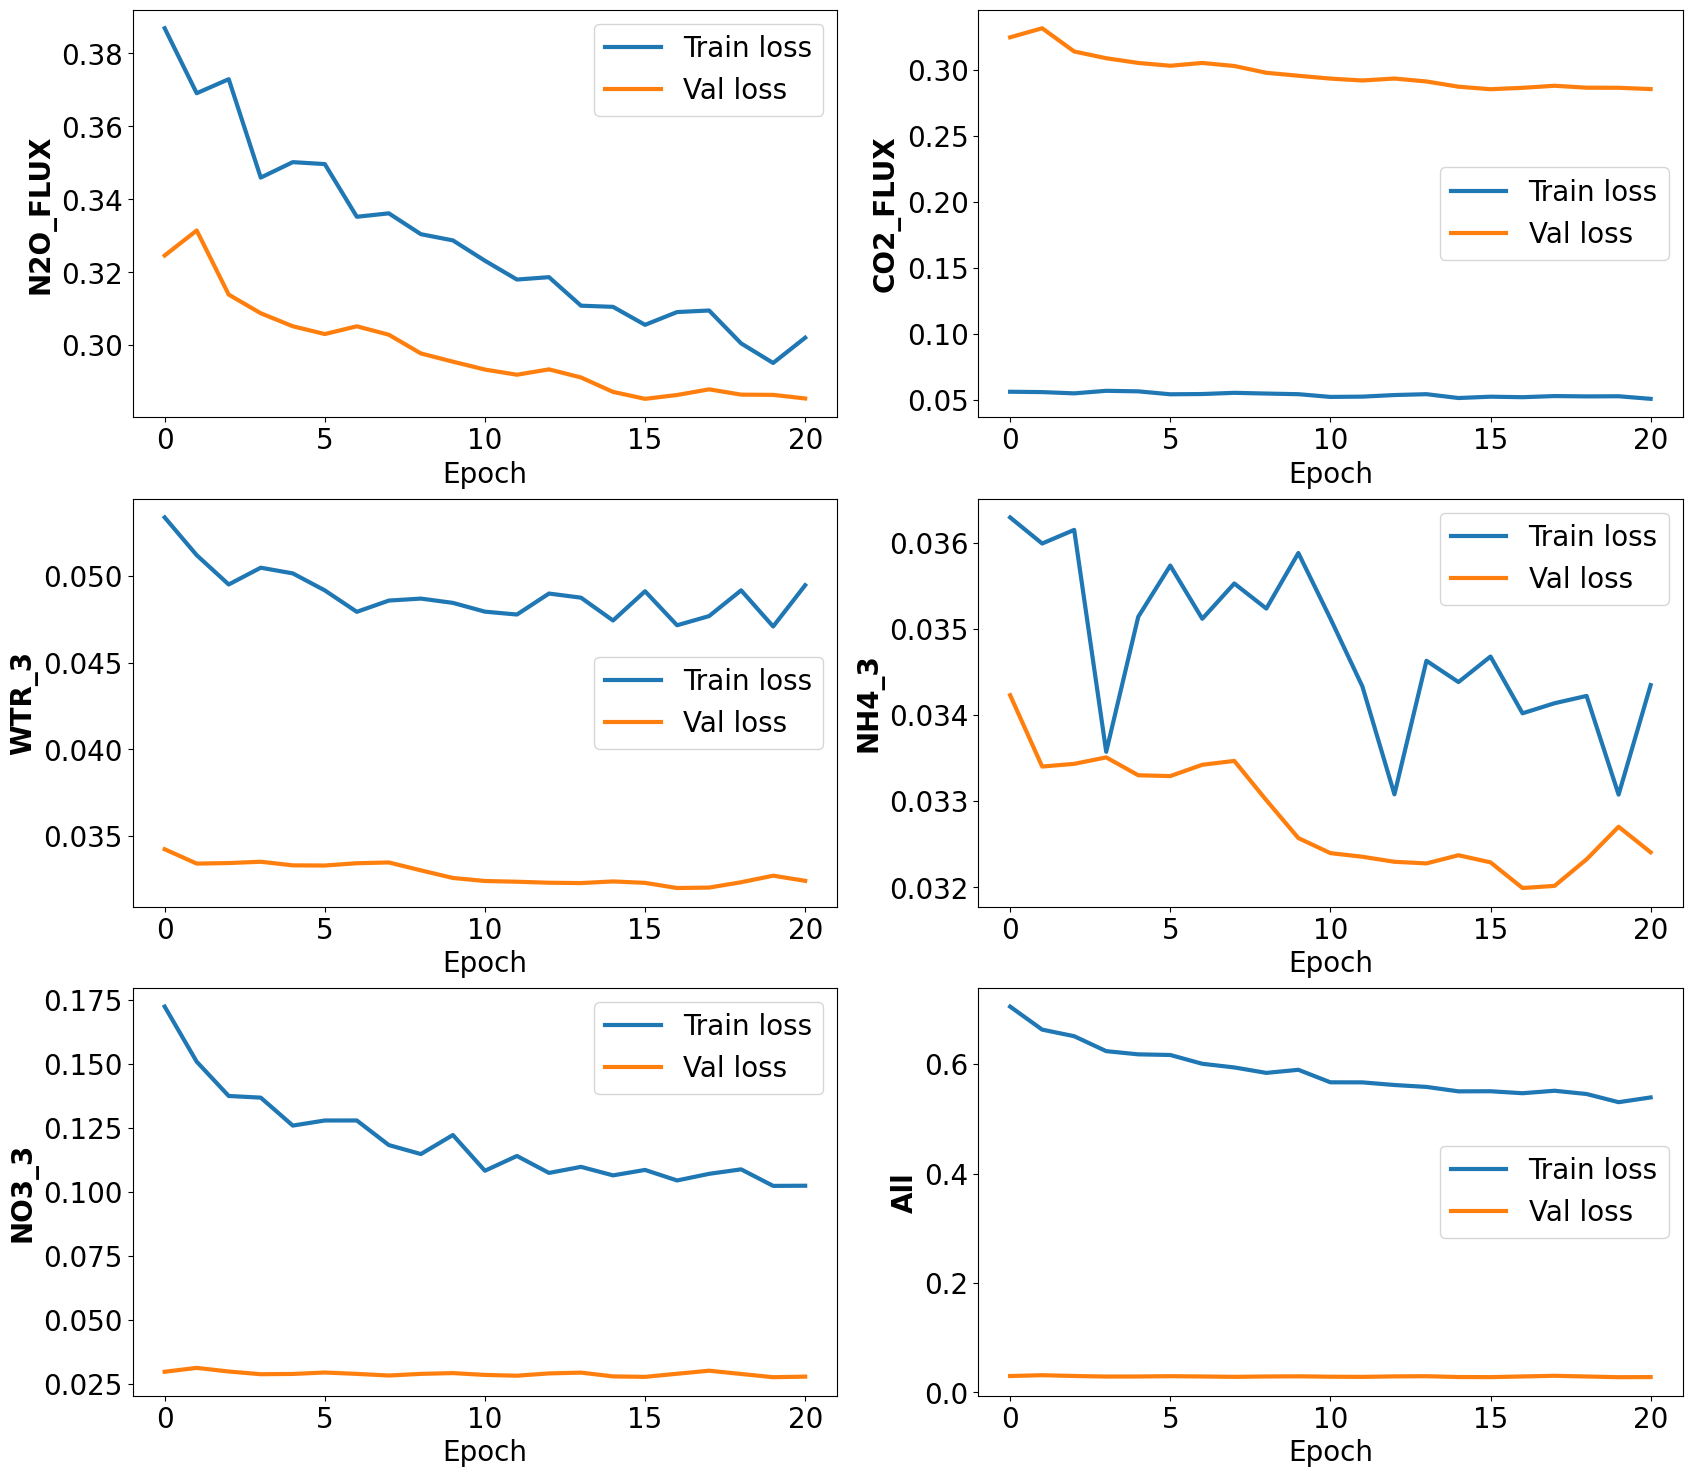

In [364]:
model.vis_loss()

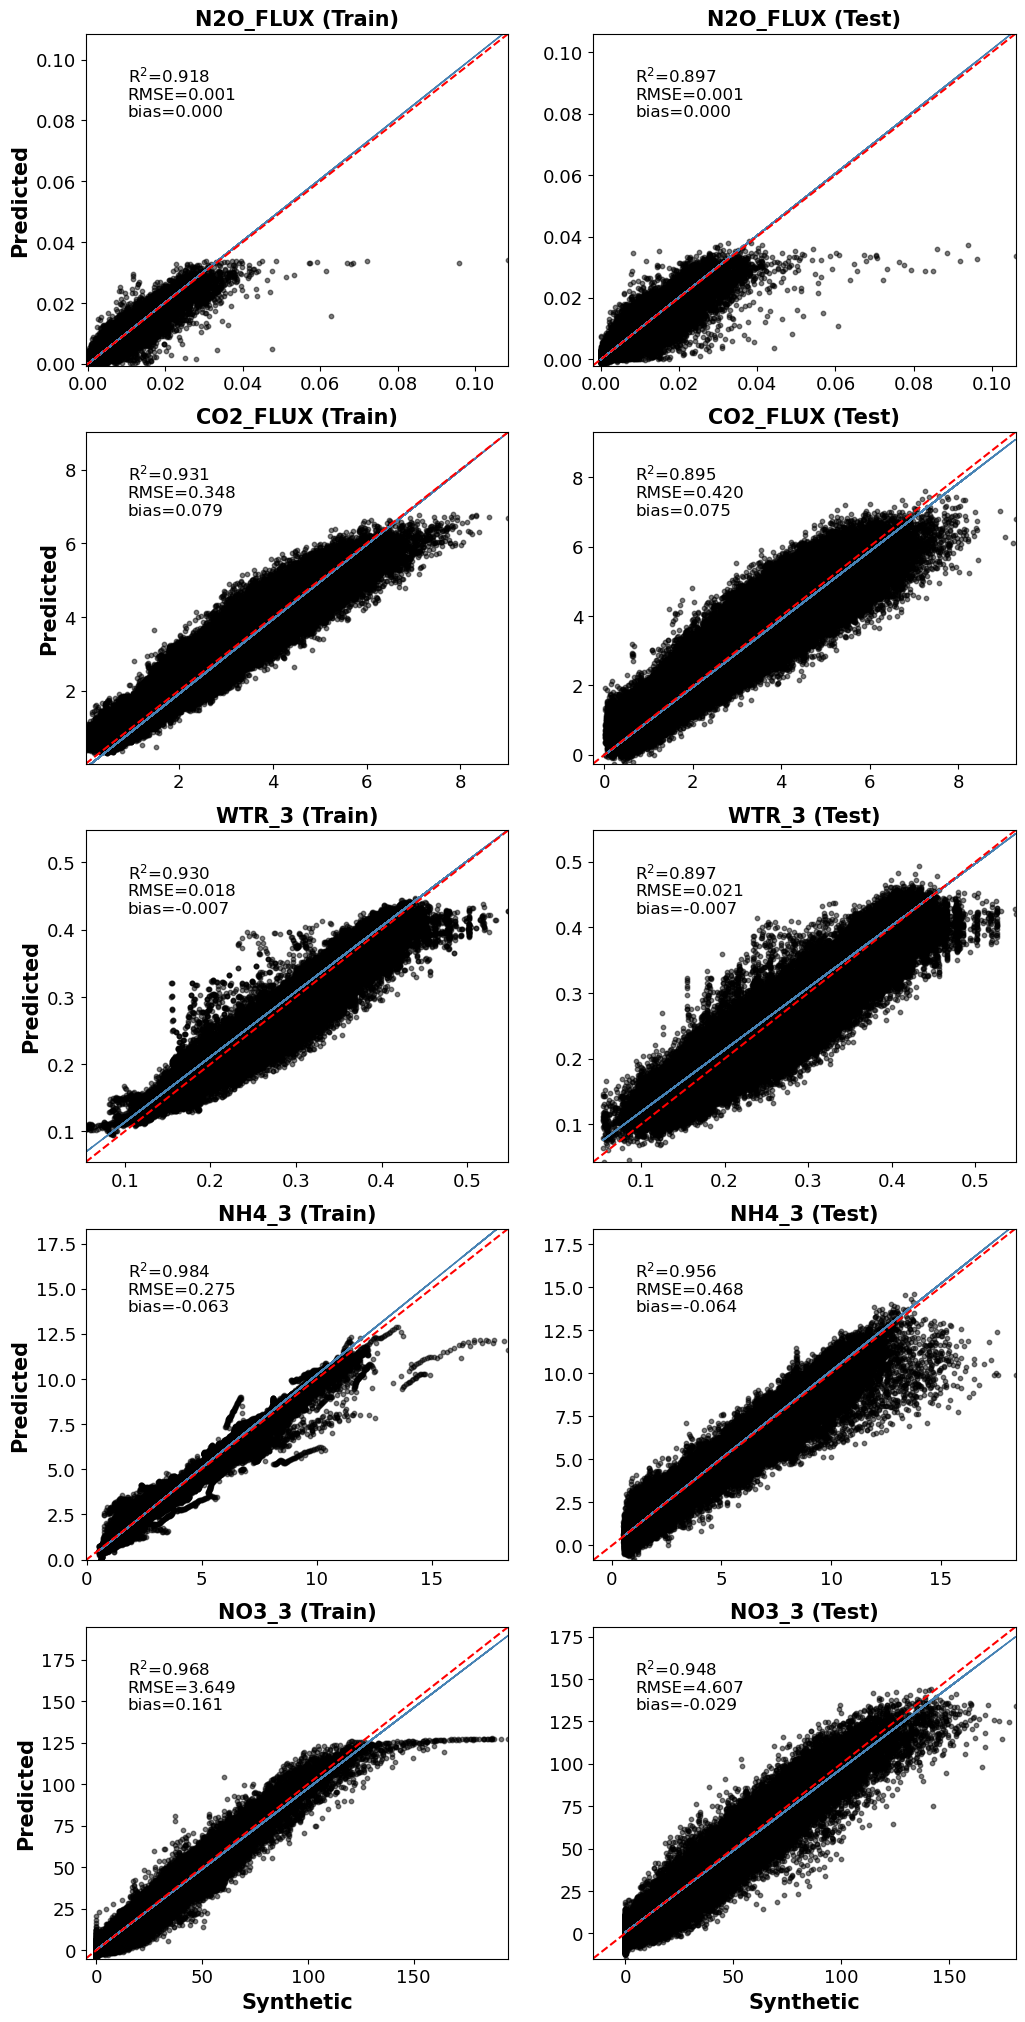

In [650]:
model.vis_scatter()

torch.Size([122, 3, 5]) torch.Size([122, 3, 5])


/var/folders/yv/lllpcq5d7g9cxbvg8bj3tg080000gn/T/ipykernel_1427/2741776226.py:4: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  var_y = torch.var(y, unbiased=False)
/var/folders/yv/lllpcq5d7g9cxbvg8bj3tg080000gn/T/ipykernel_1427/2741776226.py:4: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  var_y = torch.var(y, unbiased=False)


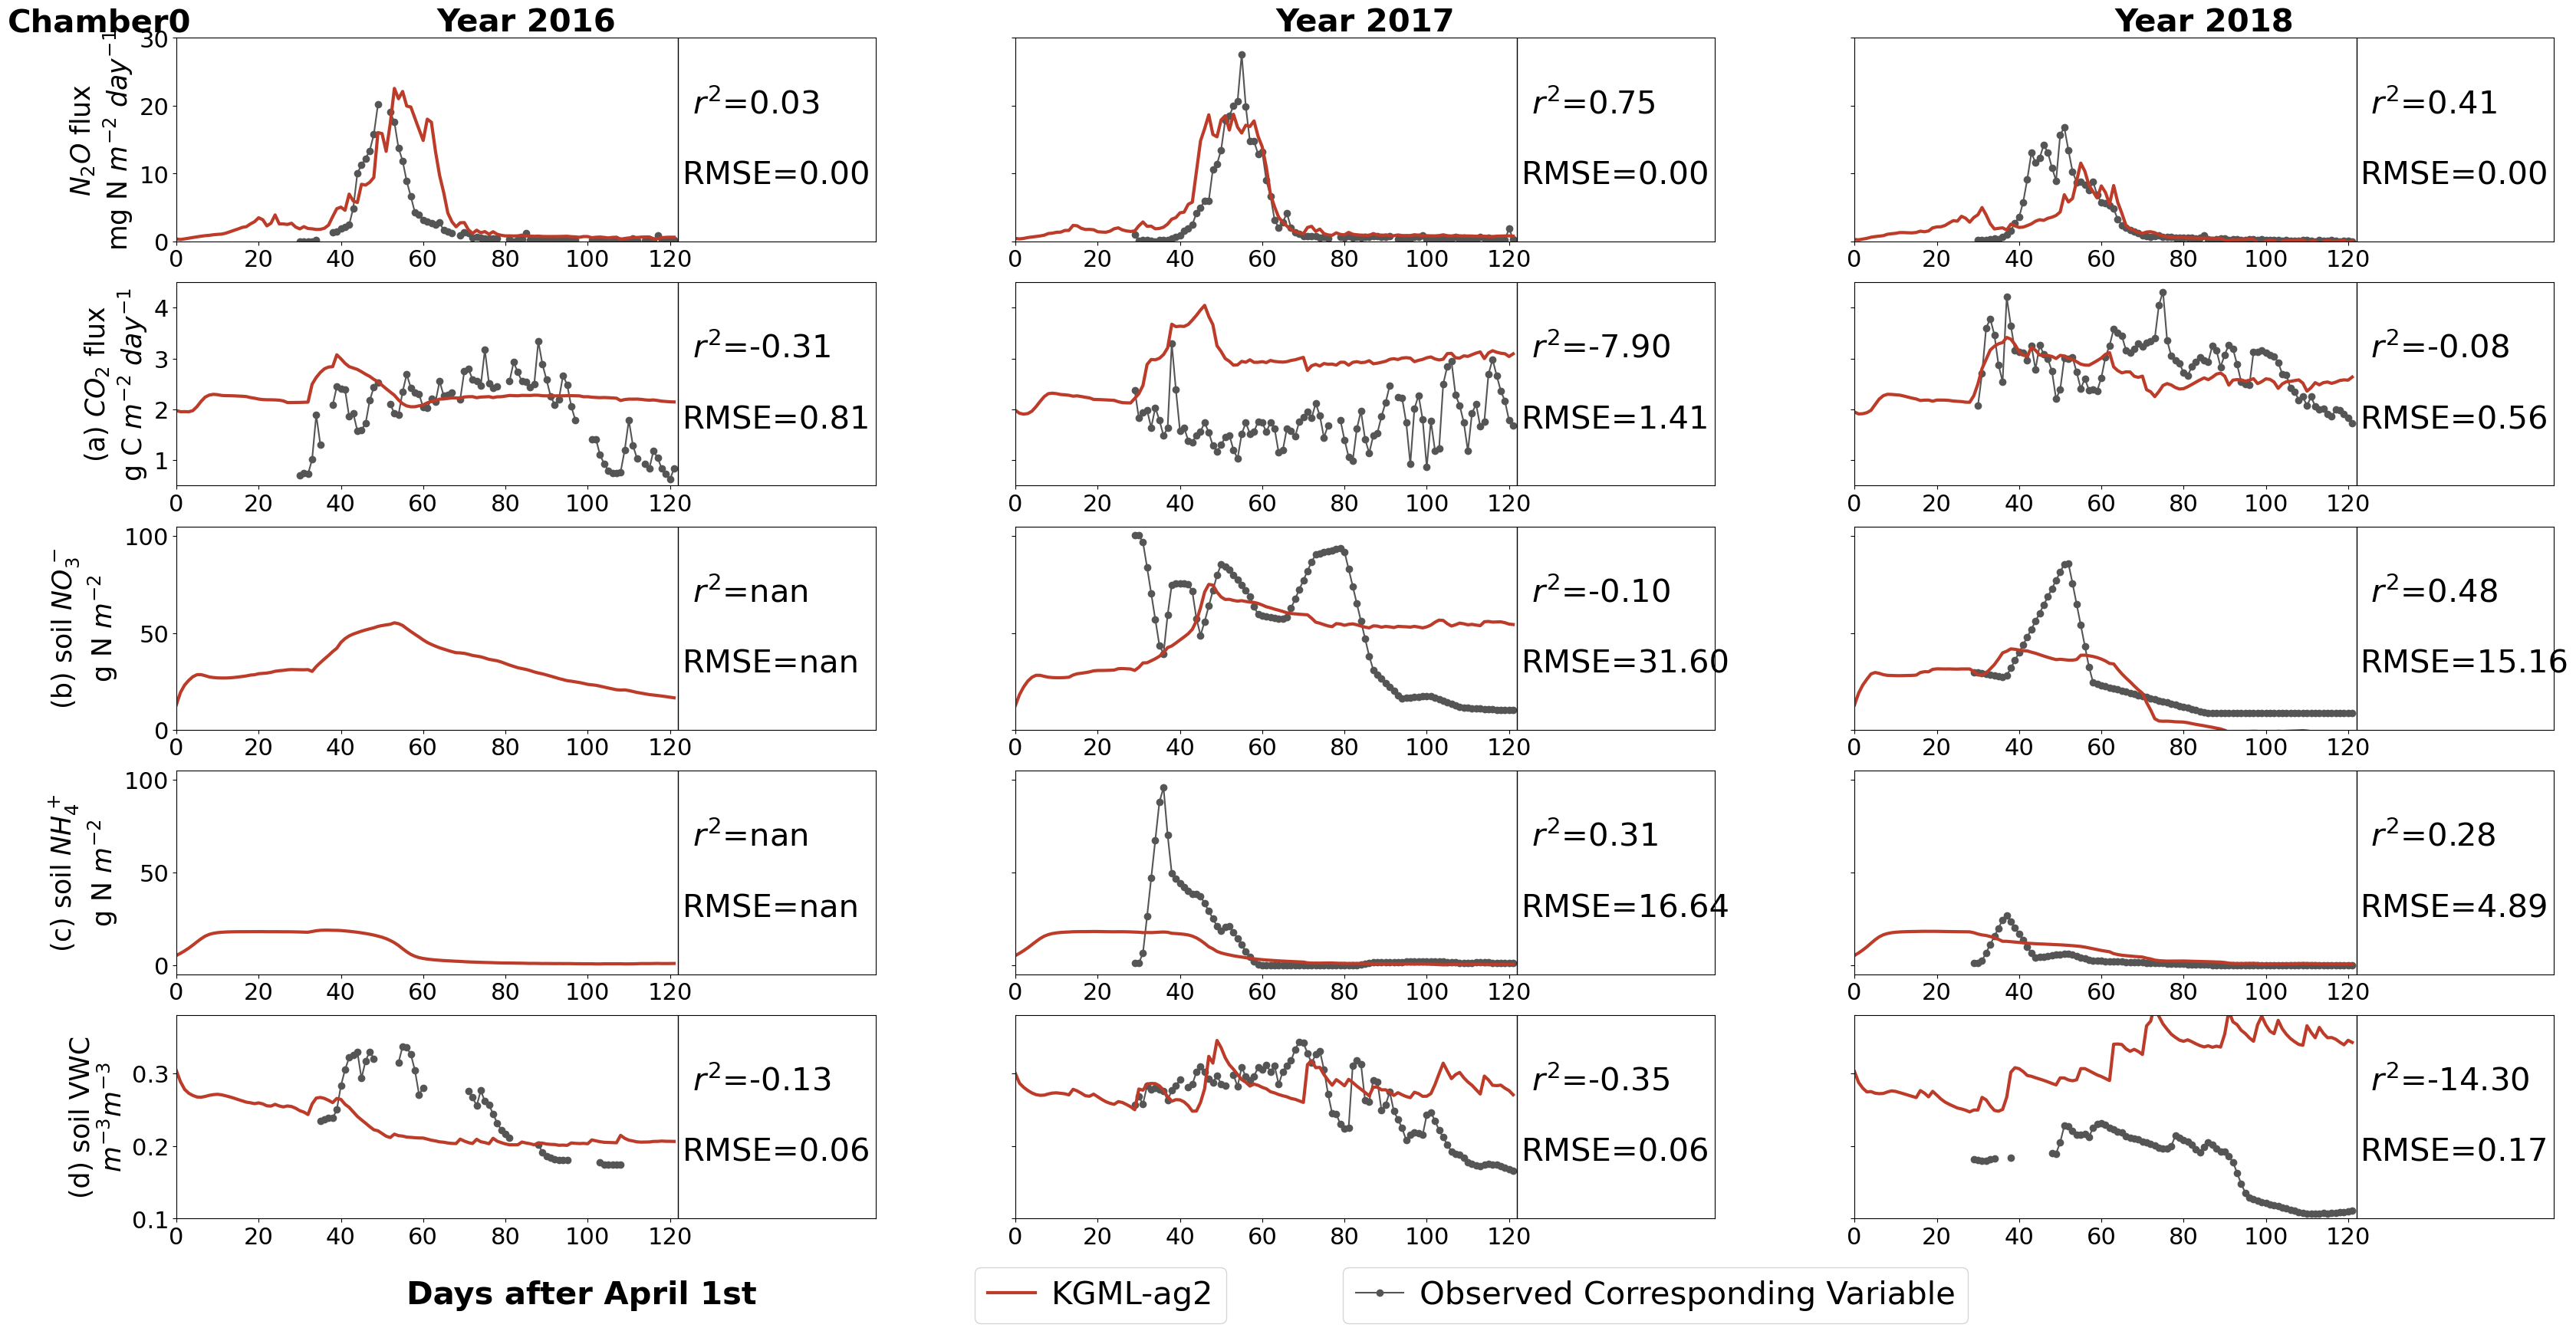

In [742]:
model_ft.vis_finetune(data_path=pred_path + model_version + '_finetune.sav')